In [1]:
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns

from simtk import unit
from openmmtools.constants import kB
temperature = 300.0 * unit.kelvin
kT = kB * temperature

import mdtraj as md

import random
import os
from pymbar import EXP

hartree_to_kT = ((1*unit.hartree).in_units_of(unit.joules)*unit.AVOGADRO_CONSTANT_NA / kT)

Correction is 2.11 (0.10) kcal/mol for ligand 0


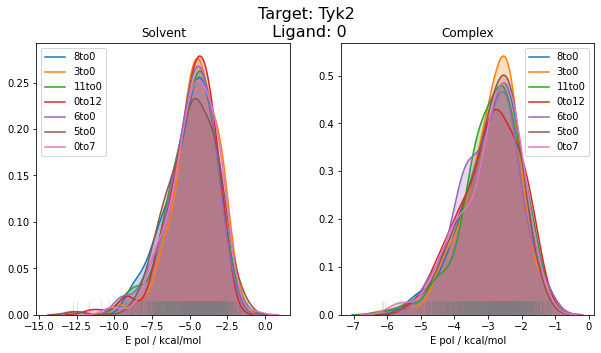

Correction is 1.67 (0.15) kcal/mol for ligand 1


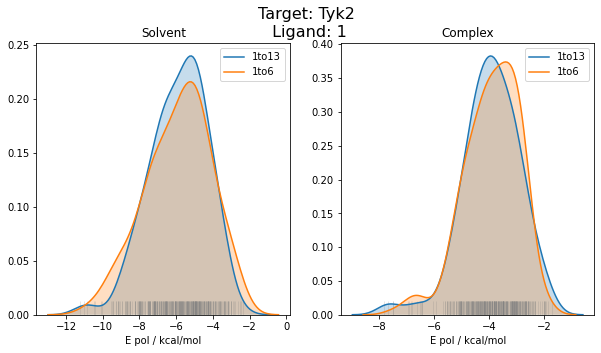

Correction is 2.38 (0.19) kcal/mol for ligand 2


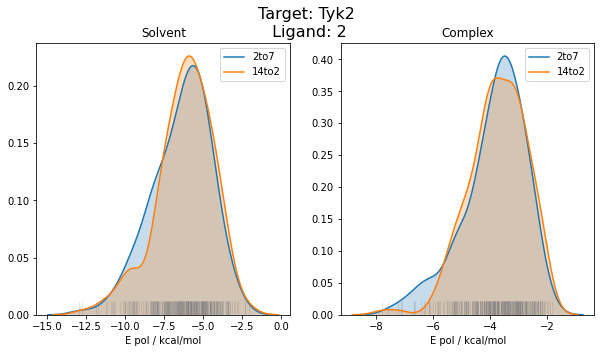

Correction is 2.31 (0.13) kcal/mol for ligand 3


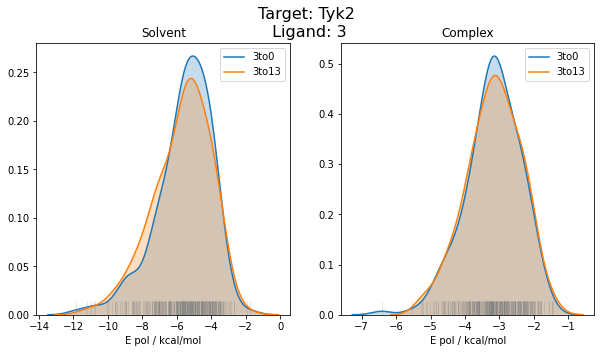

Correction is 1.84 (0.08) kcal/mol for ligand 4


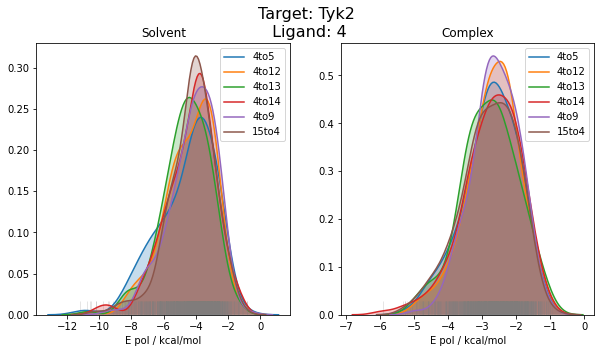

Correction is 2.26 (0.29) kcal/mol for ligand 5


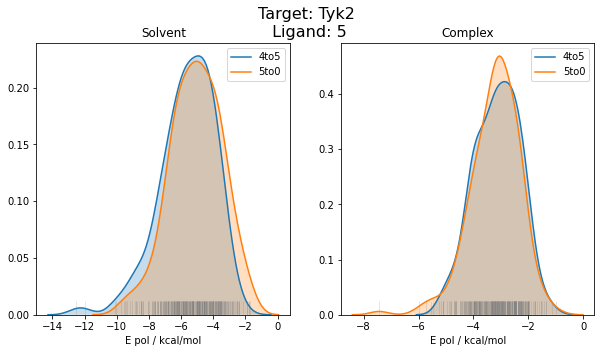

Correction is 2.26 (0.11) kcal/mol for ligand 6


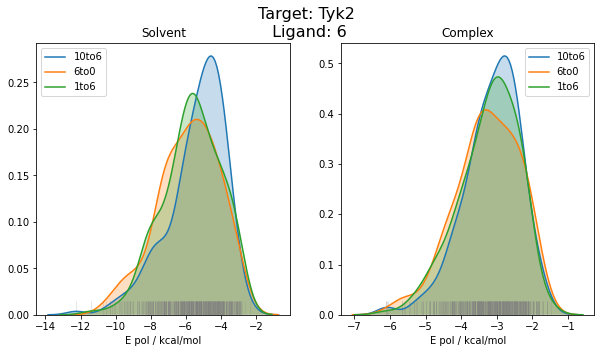

Correction is 2.18 (0.29) kcal/mol for ligand 7


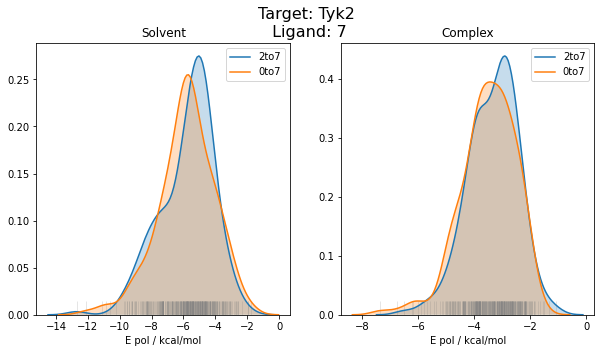

Correction is 2.26 (0.13) kcal/mol for ligand 8


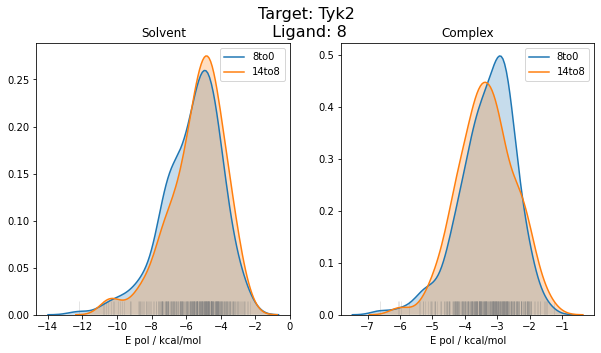

Correction is 2.35 (0.26) kcal/mol for ligand 9


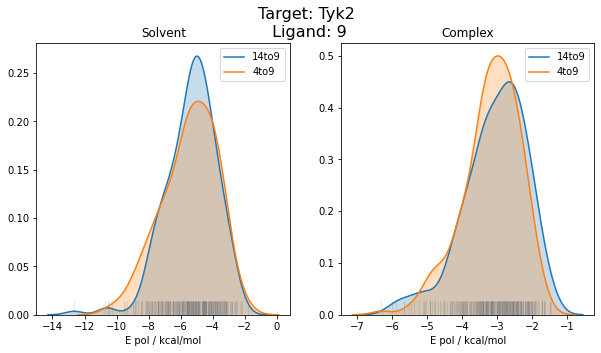

Correction is 2.42 (0.17) kcal/mol for ligand 10


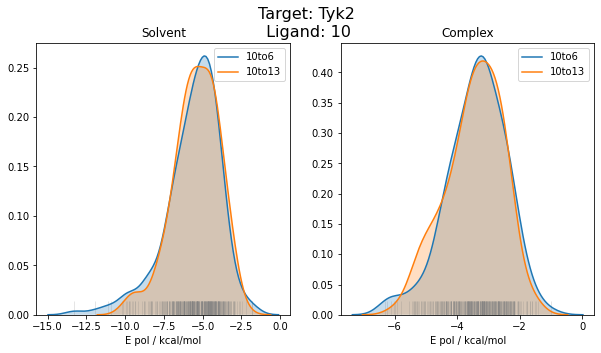

Correction is 2.01 (0.12) kcal/mol for ligand 11


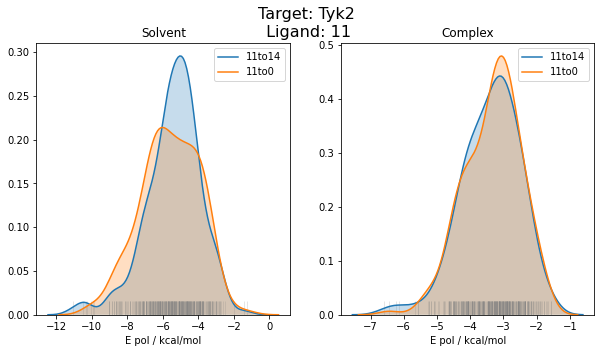

Correction is 1.81 (0.08) kcal/mol for ligand 12


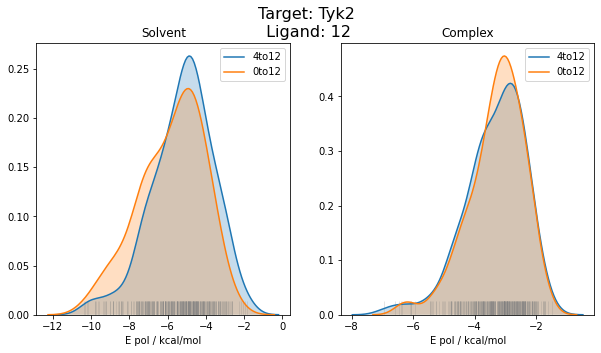

Correction is 2.61 (0.37) kcal/mol for ligand 13


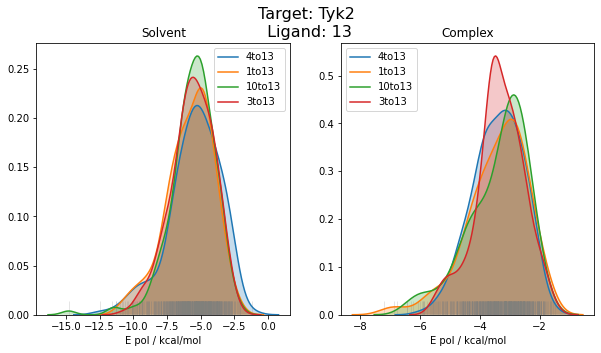

Correction is 2.18 (0.09) kcal/mol for ligand 14


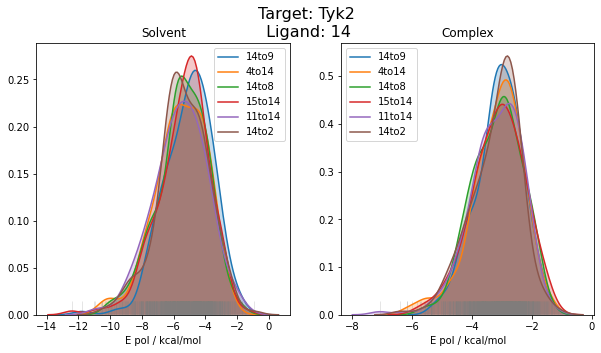

Correction is 1.95 (0.09) kcal/mol for ligand 15


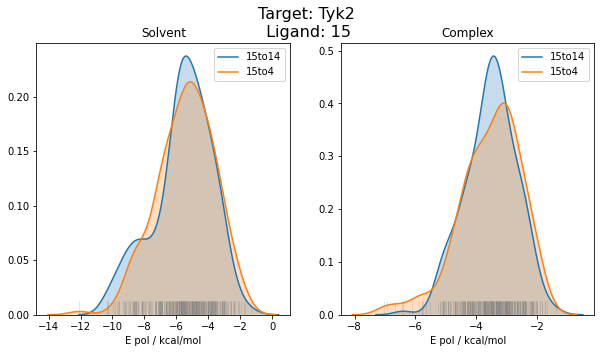

Correction is 1.66 (0.19) kcal/mol for ligand 0


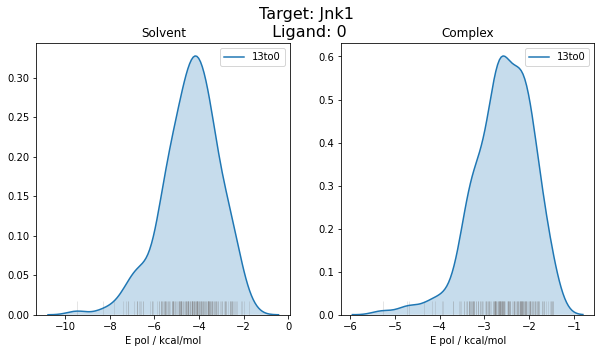

Correction is 1.65 (0.15) kcal/mol for ligand 1


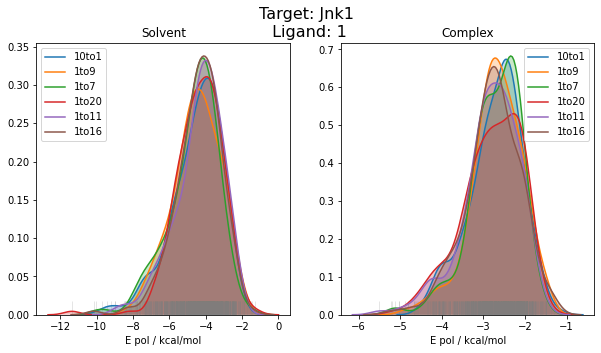

Correction is 1.66 (0.30) kcal/mol for ligand 2


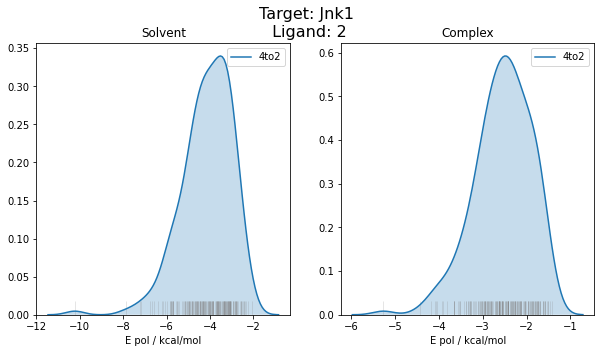

Correction is 1.42 (0.21) kcal/mol for ligand 3


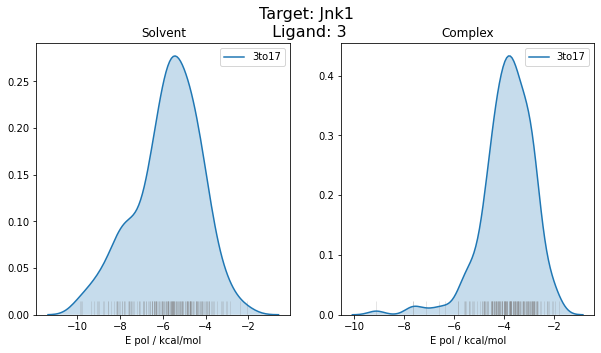

Correction is 1.48 (0.07) kcal/mol for ligand 4


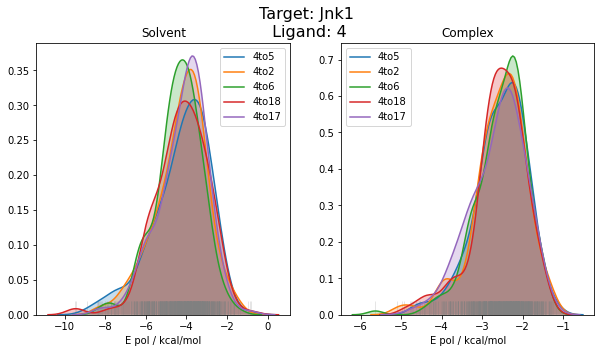

Correction is 1.55 (0.09) kcal/mol for ligand 5


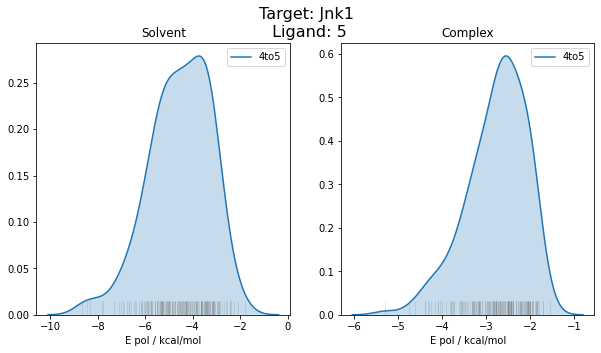

Correction is 1.96 (0.30) kcal/mol for ligand 6


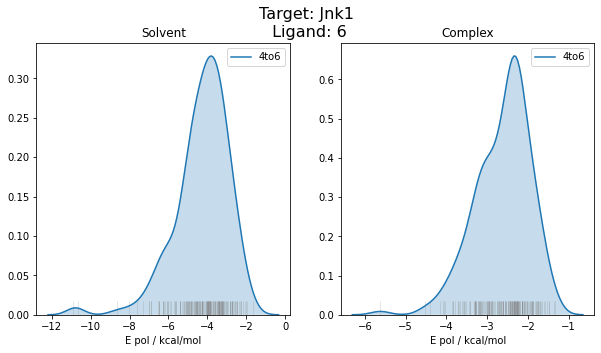

Correction is 1.36 (0.10) kcal/mol for ligand 7


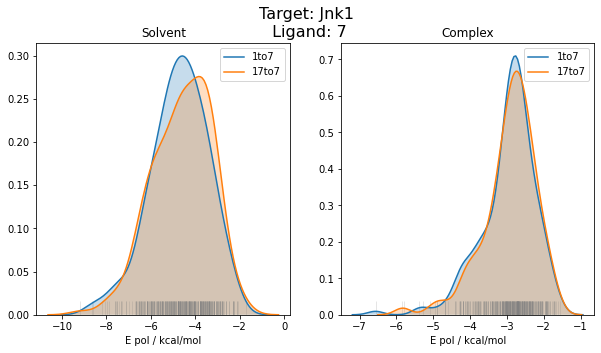

Correction is 1.51 (0.20) kcal/mol for ligand 8


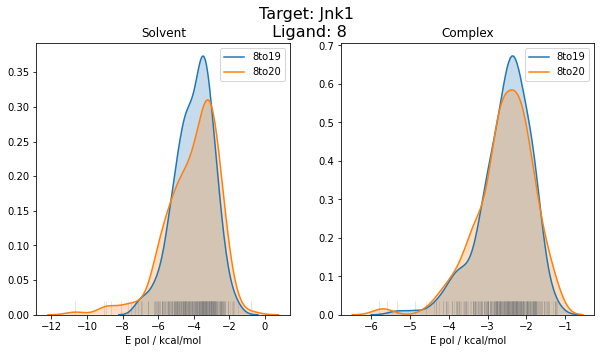

Correction is 1.32 (0.10) kcal/mol for ligand 9


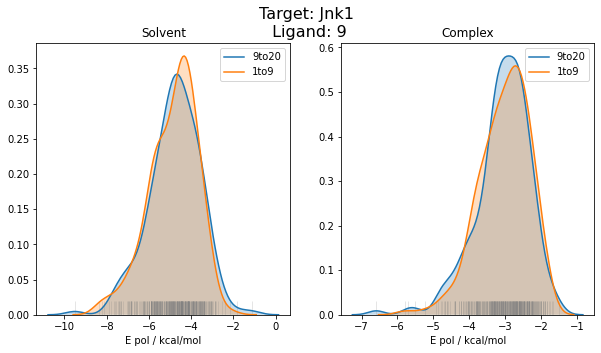

Correction is 2.88 (0.45) kcal/mol for ligand 10


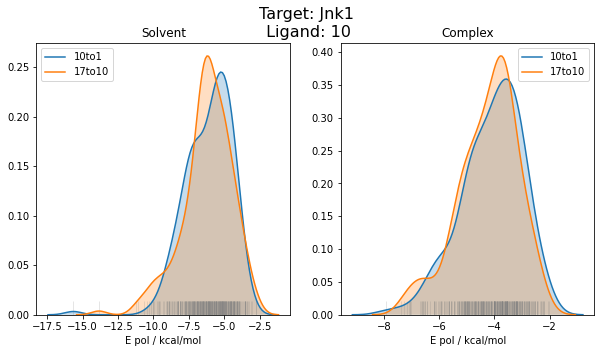

Correction is 3.24 (1.10) kcal/mol for ligand 11


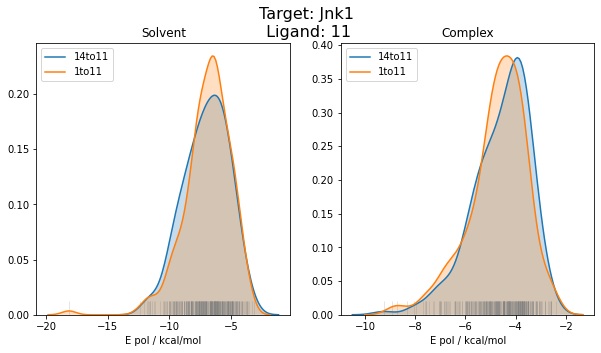

Correction is 1.62 (0.21) kcal/mol for ligand 12


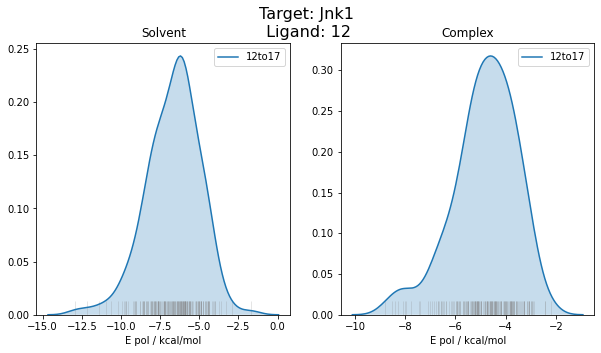

Correction is 1.77 (0.10) kcal/mol for ligand 13


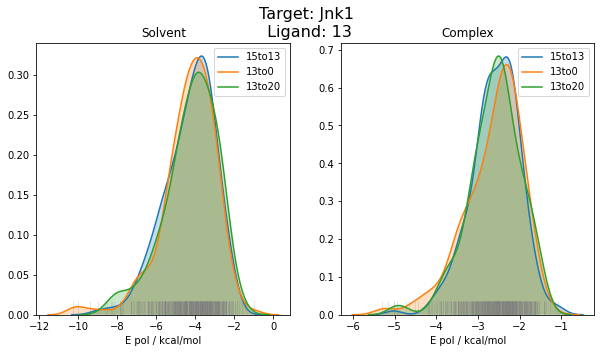

Correction is 1.71 (0.23) kcal/mol for ligand 14


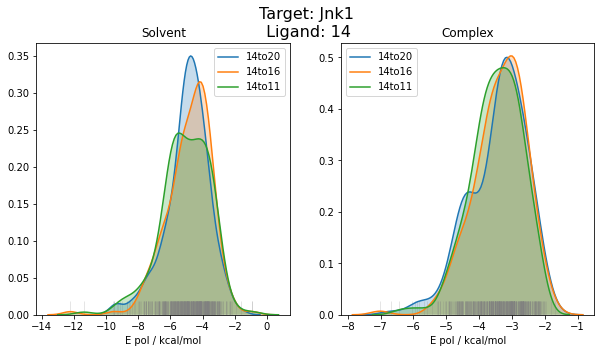

Correction is 1.70 (0.18) kcal/mol for ligand 15


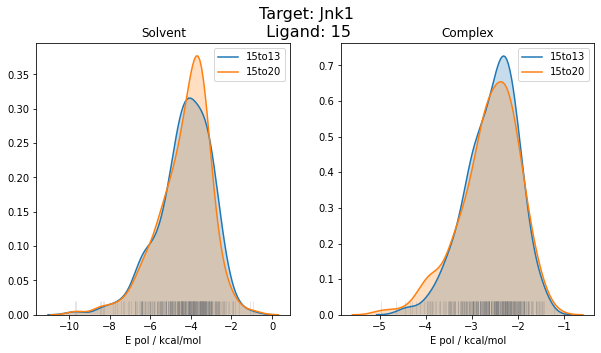

Correction is 1.52 (0.14) kcal/mol for ligand 16


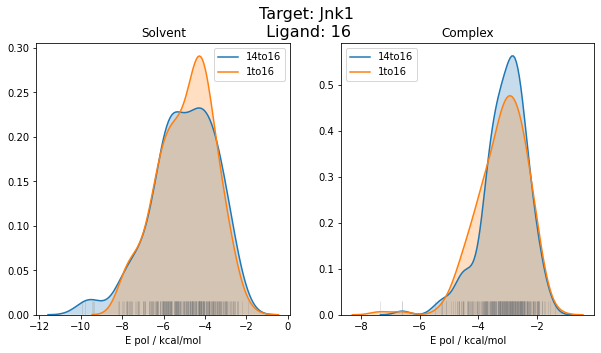

Correction is 1.51 (0.08) kcal/mol for ligand 17


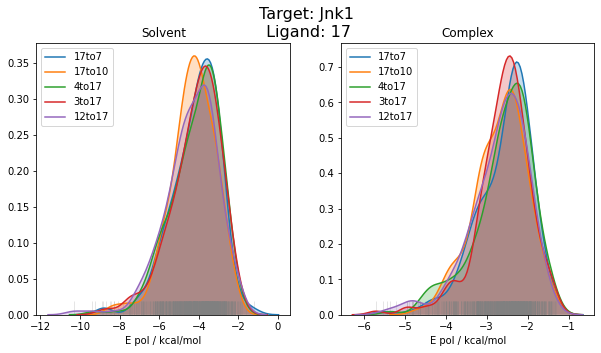

Correction is 1.60 (0.14) kcal/mol for ligand 18


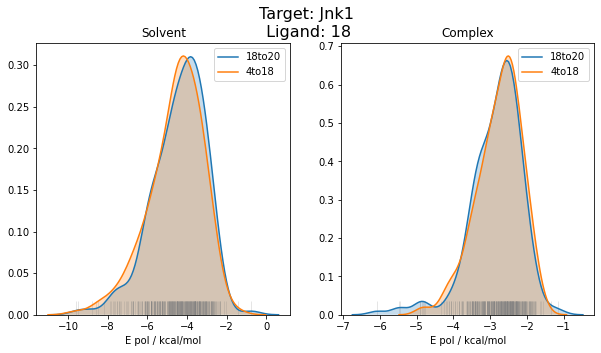

Correction is 1.49 (0.19) kcal/mol for ligand 19


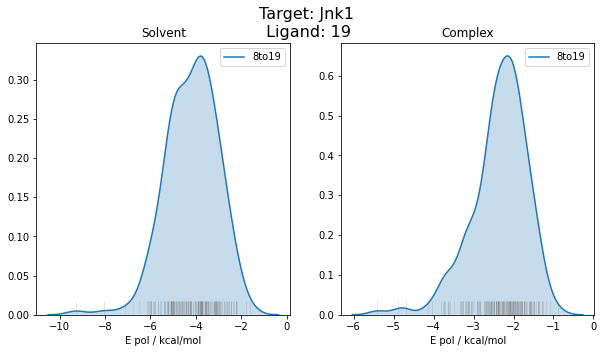

Correction is 1.89 (0.21) kcal/mol for ligand 20


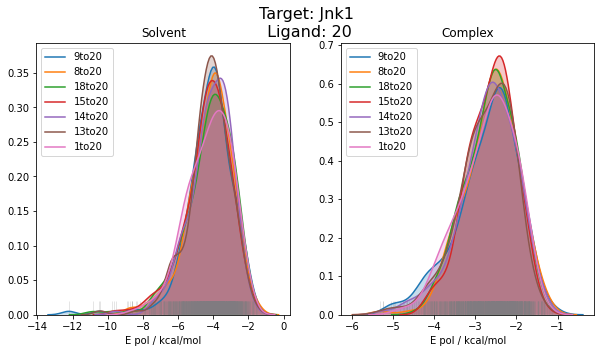

In [3]:
systems = ['tyk2','jnk1']

all_corrections = {x: {} for x in systems}
all_mm = {x: [] for x in systems}
new_results = {x: {} for x in systems}
n_bootstrap = 10
folders = ['off100']


for c, target in enumerate(systems):
    color = sns.color_palette("hls", len(systems))[c]

    for folder in folders:
        outputs = {}
        ligands = []
        for d in os.listdir(f'../{target}/{folder}/'):
            if d[-3:] == '.pi':
                results = np.load(f'../{target}/{folder}/{d}',allow_pickle=True) 
                all_mm[target].append(results)
            else:
                pair = tuple([int(i) for i in d[3:].split('to')])
                outputs[pair] = d
                ligands.append(pair[0])
                ligands.append(pair[1])

        ligands = set(ligands)
        new_results[target] = {i:{} for i in ligands}
        oldnew = {0:'old',1:'new'}

        for ligand in ligands:
            for output in outputs.keys():
                if ligand in output:
                    endstate = oldnew[output.index(ligand)]
                    solventfile = f'../{target}/{folder}/{outputs[output]}/{endstate}_solvent.npy'
                    if os.path.exists(solventfile):
                        solvent = np.load(solventfile,allow_pickle=True).flatten()[0]
                        solvent['Epol']*hartree_to_kT
                        new_results[target][ligand][f'solvent-{outputs[output]}'] = solvent['Epol']*hartree_to_kT*0.59
                    complexfile = f'../{target}/{folder}/{outputs[output]}/{endstate}_complex.npy'
                    if os.path.exists(complexfile):
                        complex = np.load(complexfile,allow_pickle=True).flatten()[0]
                        new_results[target][ligand][f'complex-{outputs[output]}'] = complex['Epol']*hartree_to_kT*0.59           

        for ligand in new_results[target].keys():
            if len(new_results[target][ligand]) > 0:
                new_solvent_for_lig = []
                new_complex_for_lig = []
                fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(10,5))
                for thing in new_results[target][ligand]:
                    if 'solvent' in thing:
                        Epol = new_results[target][ligand][thing]
                        if len(Epol) != 200:
                            print(ligand)
                            continue
                        sns.kdeplot(Epol,label=thing.split('-lig')[1],shade=True,ax=axes[0])
                        sns.rugplot(Epol,ax=axes[0],alpha=0.2,color='grey')
                        new_solvent_for_lig.extend(Epol)
                    elif 'complex' in thing:
                        Epol = new_results[target][ligand][thing]
                        if len(Epol) != 200:
                            print(ligand)
                            continue
                        sns.kdeplot(Epol,label=thing.split('-lig')[1],shade=True,ax=axes[1])
                        sns.rugplot(Epol,ax=axes[1],alpha=0.2,color='grey')
                        new_complex_for_lig.extend(Epol)


                if len(new_solvent_for_lig) > 0 and len(new_complex_for_lig) > 0:
                    bootstraps = []
                    
                    for _ in range(n_bootstrap):
                        comp = random.choices(new_complex_for_lig, k=len(new_complex_for_lig))
                        sol = random.choices(new_solvent_for_lig, k=len(new_solvent_for_lig))
                        corr_comp, err_comp = EXP(np.asarray(comp))
                        corr_sol, err_sol = EXP(np.asarray(sol))
                        bootstraps.append((corr_comp - corr_sol)*0.593)
                    print(f'Correction is {np.mean(bootstraps):.2f} ({np.std(bootstraps):.2f}) kcal/mol for ligand {ligand}')
                    all_corrections[target][ligand] = (np.mean(bootstraps), np.std(bootstraps))
                axes[0].set_title('Solvent')
                axes[1].set_title('Complex')
                axes[0].set_xlabel('E pol / kcal/mol')
                axes[1].set_xlabel('E pol / kcal/mol')
                fig.suptitle(f"Target: {target.capitalize()}\n Ligand: {ligand}", fontsize=16)
                plt.show()

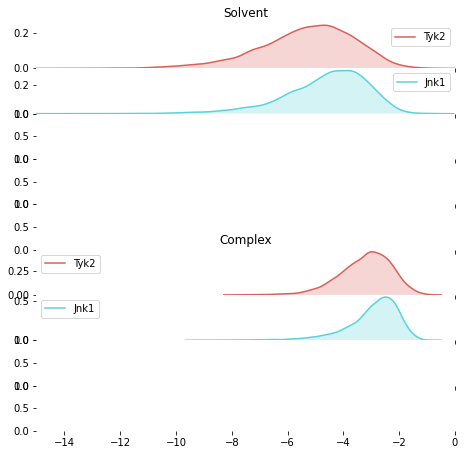

In [4]:
all_solvent = []
all_complex = []
bins = np.linspace(-16,0,100)
fig, axes = plt.subplots(ncols=1,nrows=9,figsize=(7.5,7.5),sharex=True)
for c,target in enumerate(new_results):
    color = sns.color_palette("hls", len(systems))[c]
    target_solvent = []
    target_complex = []
    for l in new_results[target].values():
        for thing in l.keys():
            if 'solvent' in thing:
                target_solvent.extend(l[thing])
            else:
                target_complex.extend(l[thing])
    sns.kdeplot(target_solvent,label=f'{target.capitalize()}',shade=True,color=color,ax=axes[0+c])
    sns.kdeplot(target_complex,label=f'{target.capitalize()}',shade=True,color=color,ax=axes[5+c])
    
axes[0].set_title('Solvent')
axes[5].set_title('Complex')
sns.despine(top=True, right=True, left=True, bottom=True)
plt.subplots_adjust(hspace=0.)
plt.xlim(-15,0)
plt.savefig('/Users/brucemah/Desktop/temp.pdf',transparent=True)
plt.show()

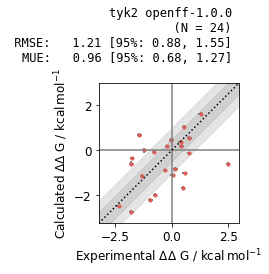

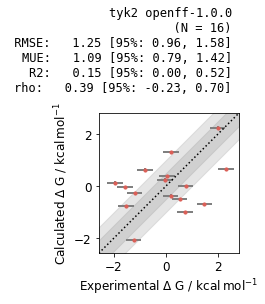

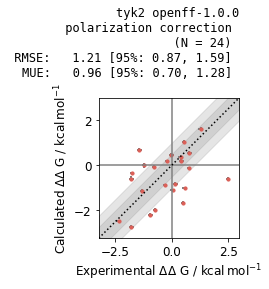

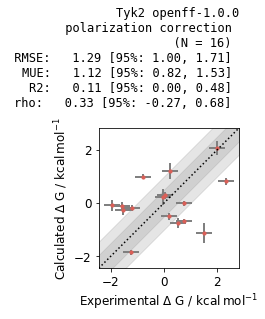

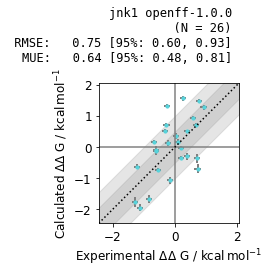

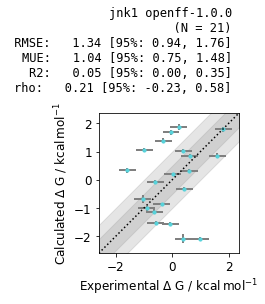

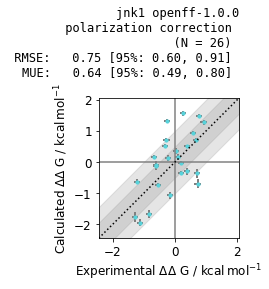

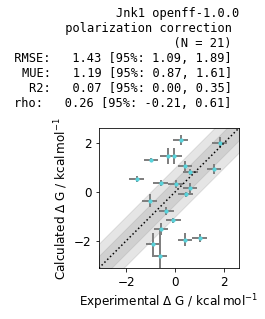

In [5]:
all_experimental = {'tyk2':[-9.540000 , -10.940000 , -8.980000 , -11.310000 , -9.210000 , -8.260000 , -10.980000 , -7.750000 , -9.560000 , -7.420000 , -11.280000 , -9 , -9.700000 , -11.700000 , -9.780000 , -10.530000],
                'thrombin':[-8.46 ,-8.25 ,-7.86 ,-7.48 ,-9.18 ,-8.22 ,-8.32 ,-7.58 ,-8.89 ,-8.91 ,-8.56],
                'mcl1':[-8.235840 ,-6.662619 ,-6.875244 ,-7.601134 ,-8.812646 ,-7.919517 ,-9.225852 ,-7.689612 ,-6.583017 ,-7.019008 ,-8.448465 ,-9.328297     ,-6.621490 ,-8.431671 ,-7.026800 ,-8.953565 ,-7.853212 ,-9.779976 ,-8.673381 ,-8.828544 ,-6.939406 ,-7.253025 ,-7.955657 ,-8.079437 ,-8.361457 ,-9.499793 ,-7.129245 ,-8.407336 ,-9.407899 ,-9.062252 ,-6.116391 ,-5.775532 ,-9.038871 ,-9.258083 ,-9.964869 ,-8.179023 ,-8.915091 ,-8.953565 ,-8.896747 ,-7.580925 ,-6.869192 ,-7.034696],
                'jnk1':[-8.67377 ,-9.993231 ,-8.702592 ,-8.702592 ,-8.49337 ,-9.174299 ,-7.286071 ,-9.675922 ,-8.105004 ,-9.465222 ,-10.141692 ,-10.093111 ,-10.682977 ,-8.483096 ,-9.699398 ,-9.142359 ,-9.740725 ,-9.413821 ,-9.083236 ,-7.512318 ,-8.872536]
}
import networkx as nx
from arsenic import plotting, stats

for c,target in enumerate(systems):
    color = sns.color_palette("hls", len(systems))[c]
    mm_g = nx.OrderedDiGraph()

    experimental = all_experimental[target]
    
    for sim in all_mm[target]:
        ligA = int(sim.directory[3:].split('to')[0])
        ligB = int(sim.directory[3:].split('to')[1])
        mm_g.add_edge(ligA, ligB,calc_DDG=sim.bindingdg/sim.bindingdg.unit, calc_dDDG=sim.bindingddg/sim.bindingddg.unit,exp_DDG=(experimental[ligA] - experimental[ligB]),exp_dDDG=0.1)
        
        
    f_i_calc, C_calc = stats.mle(mm_g, factor='calc_DDG')
    
    variance = np.diagonal(C_calc)
    for i, (node, f_i, df_i) in enumerate(zip(mm_g.nodes(data=True), f_i_calc, variance**0.5)):
        node[1]['calc_DG'] = f_i
        node[1]['calc_dDG'] = df_i
        node[1]['exp_DG'] = experimental[i]
        node[1]['exp_dDG'] = 0.3
    plotting.plot_DDGs(mm_g,title=f'{target} openff-1.0.0',color=color)
    plotting.plot_DGs(mm_g,title=f'{target} openff-1.0.0',color=color)

    
    import copy

    pol_g = copy.deepcopy(mm_g)

    for node in pol_g.nodes(data=True):
        try:
            node[1]['calc_DG'] =  node[1]['calc_DG']- all_corrections[target][node[0]][0]
            node[1]['calc_dDG'] =  (node[1]['calc_dDG']**2 + all_corrections[target][node[0]][1]**2)**0.5 
        except:
            print(f'No correction for {target} ligand {node[0]}')
    plotting.plot_DDGs(pol_g,title=f'{target} openff-1.0.0\n polarization correction',color=color)

    plotting.plot_DGs(pol_g,title=f'{target.capitalize()} openff-1.0.0\n polarization correction',color=color)

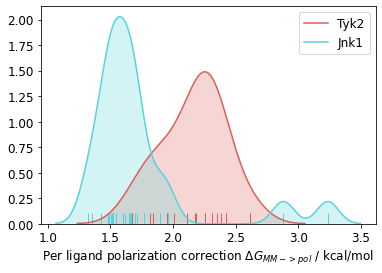

In [6]:
for c, target in enumerate(systems):
    color = sns.color_palette("hls", len(systems))[c]
    sns.kdeplot([i[0] for i in all_corrections[target].values()],label=target.capitalize(),shade=True,color=color)
    sns.rugplot([i[0] for i in all_corrections[target].values()],color=color)

plt.xlabel('Per ligand polarization correction $\Delta G_{MM->pol}$ / kcal/mol')
plt.legend()
plt.show()

<mdtraj.Topology with 3 chains, 624 residues, 1893 atoms, 1271 bonds>
<mdtraj.Trajectory with 201 frames, 1893 atoms, 624 residues, and unitcells>


KeyError: 'solvent-lig0to12'

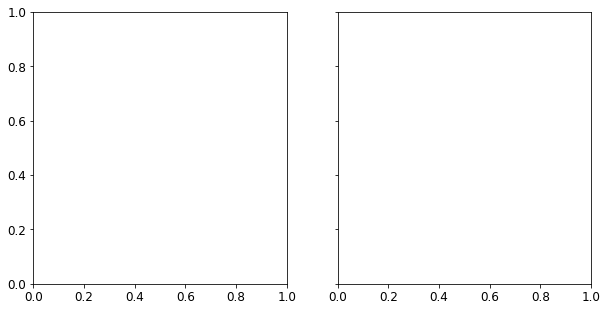

In [7]:
ax = {'solvent':0, 'complex':1}


fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(10,5),sharey=True)
phase = 'solvent'
directory = 'lig0to12'

# if str(ligand) == thing.split('to')[1]:
#     state = 'new'
# else:
#     state = 'old'

state = 'old'

topology = md.load(f'../tyk2/off100/{directory}/{state}_{phase}.pdb').topology
t = md.load(f'../tyk2/off100/{directory}/{state}_{phase}_aligned.dcd', top=topology)

print(topology)
print(t)
ligand_ids = []
ions_ids = []
for r in topology.residues:
    if r.name == 'MOL': 
        for a in r.atoms:
            ligand_ids.append(a.index)
    if r.name == 'NA': 
          for a in r.atoms:
            ions_ids.append(a.index)

comparisons = [[i,j] for i in ligand_ids for j in ions_ids]
ion_dist = md.compute_distances(t,comparisons)

closest_ion = np.min(ion_dist,axis=1)

sns.regplot(10*closest_ion[1:],new_results[target][0][f'{phase}-{directory}']['Epol']*hartree_to_kT,ax=axes[ax[phase]],label=directory)

axes[0].set_xlabel('Distance between ligand and closest Na+ / A')
axes[0].set_ylabel('E pol / kT')
axes[0].legend()
axes[1].set_xlabel('Distance between ligand and closest Na+ / A')
axes[1].set_ylabel('E pol / kT')
axes[1].legend()
fig.suptitle(f"Ligand {ligand} E-polarisation", fontsize=16)
plt.show()